In [69]:
from glob import glob
import pandas as pd
import json
from sklearn.metrics import confusion_matrix

# Auswertung der generierten Daten

In [70]:
files = glob("../feedback/*.json")

In [71]:
files

['../feedback/Anett.json',
 '../feedback/Marcel.json',
 '../feedback/Petra.json',
 '../feedback/Nicole.json',
 '../feedback/Anastasia.json',
 '../feedback/Pascal.json',
 '../feedback/Eva.json']

In [72]:
feedback = []

for file in files:
    with open(file) as f:
        feedback.extend(json.load(f))

In [73]:
feedback_data = []

for game_id, f in enumerate(feedback):
    for question_id, result in enumerate(f["gameResults"]):
        d = {col: val for col, val in f.items() if col != "gameResults"}
        d["game_id"] = game_id
        d["question_pos"] = question_id
        for col, value in result.items():
            d[col] = value
        feedback_data.append(d)

In [74]:
feedback_data = pd.DataFrame(feedback_data)

# Alle E-Mail-Adressen mit Namen auslesen

In [93]:
feedback_data[feedback_data["email"] != ""][["name", "email"]].drop_duplicates()

,name,email
50,Hase,anett.pohle-monetha@anacision.de
100,Marcel,marcel
200,Nicole,hello@gmail.com
210,Peter,peterlustig@yahoo.de
220,Gustav,gustav_gans@aol.com


# Auswertung

## Geschwindigkeit insgesamt mit und ohne KI

In [76]:
feedback_data.drop_duplicates("game_id").groupby("aiMode")["totalTime"].agg(
    ["mean", "median", "min", "max"]
)

,mean,median,min,max
aiMode,,,,
False,109.662791,90.80,14.1,294.9
True,57.485294,49.55,17.1,164.6


## Geschwindigkeit pro Frage mit und ohne KI

In [77]:
feedback_data.groupby("aiMode")["responseTime"].agg(["mean", "median", "min", "max"])

,mean,median,min,max
aiMode,,,,
False,9.977151,7.3235,0.060,68.663
True,4.810821,3.1460,0.578,46.331


# Anzahl der korrekten Antworten mit und ohne KI

In [78]:
feedback_data.drop_duplicates("game_id").groupby("aiMode")["correct"].agg(
    ["mean", "median", "min", "max"]
)

,mean,median,min,max
aiMode,,,,
False,8.465116,9.0,2,10
True,9.852941,10.0,8,10


## Werden Teilnehmende mit der Zeit schneller? (KI vs. ohne KI)

<Axes: title={'center': 'Durchschn. Antwortzeit pro Frage an Position (mit KI)'}, xlabel='Frageposition', ylabel='Antwortzeit in Sekunden'>

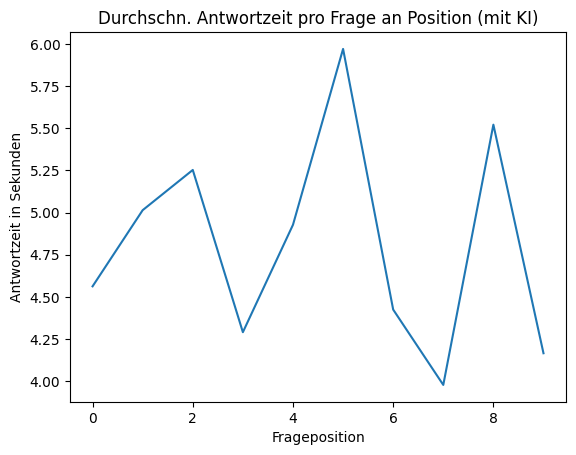

In [79]:
feedback_data[feedback_data["aiMode"]].groupby("question_pos")[
    "responseTime"
].mean().plot(
    title="Durchschn. Antwortzeit pro Frage an Position (mit KI)",
    xlabel="Frageposition",
    ylabel="Antwortzeit in Sekunden",
)

<Axes: title={'center': 'Durchschn. Antwortzeit pro Frage an Position (ohne KI)'}, xlabel='Frageposition', ylabel='Antwortzeit in Sekunden'>

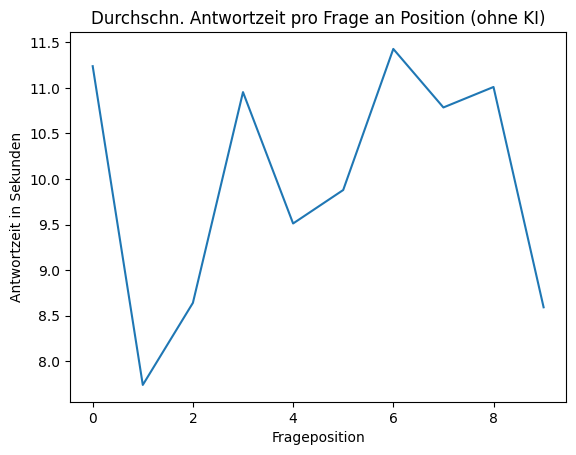

In [80]:
feedback_data[~feedback_data["aiMode"]].groupby("question_pos")[
    "responseTime"
].mean().plot(
    title="Durchschn. Antwortzeit pro Frage an Position (ohne KI)",
    xlabel="Frageposition",
    ylabel="Antwortzeit in Sekunden",
)

# Welche Kategorie wird wie oft getippt?

In [81]:
possible_depts = [
    "Finanzabteilung",
    "Rechtsabteilung",
    "Personalabteilung",
    "Leitungsebene",
    "Kundenservice",
]

In [82]:
# Assuming feedback_data is already defined
incorrect_feedback = feedback_data[["correctDept", "playerChoice"]]

conf_matrix = confusion_matrix(
    incorrect_feedback["correctDept"], incorrect_feedback["playerChoice"]
)

conf_matrix_df = pd.DataFrame(conf_matrix, index=possible_depts, columns=possible_depts)

conf_matrix_df

,Finanzabteilung,Rechtsabteilung,Personalabteilung,Leitungsebene,Kundenservice
Finanzabteilung,124,0,6,4,7
Rechtsabteilung,0,111,4,4,3
Personalabteilung,2,7,148,8,2
Leitungsebene,0,4,2,176,1
Kundenservice,2,10,2,3,140
